<a href="https://colab.research.google.com/github/EugenHotaj/experimental/blob/master/optimal_investing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import FuncFormatter

style.use('fivethirtyeight')

In [ ]:
# Accumulate 50k dollars every year that we want to invest.
# * Lump sum at start of year.
# * DCA over the whole year.
# * DCA over 6 months.
# * DCA over 3 months.
# * DCA over 1 month.

In [ ]:
spy = pd.read_csv("SPY.csv")[["Date", "Adj Close"]]
spy["Date"] =  pd.to_datetime(spy["Date"], format="%Y-%m-%d")

In [ ]:
# Calculate average yearly returns.
spy["is_year_end"] = spy["Date"].shift(-1).dt.year - spy["Date"].dt.year
spy.loc[spy["is_year_end"] != 0, "is_year_end"] = 1.0
spy["is_year_end"] = spy["is_year_end"].astype("bool")

boy_price = spy[spy["is_year_end"]]["Adj Close"]
eoy_price = spy[spy["is_year_end"]].shift(-1)["Adj Close"] 
y_returns = ((eoy_price - boy_price) / boy_price)

print(f"SPY average yearly return: {y_returns.mean():.2%}")

SPY average yearly return: 11.18%


In [ ]:
in_total = 1_000_000

In [ ]:
def plot_returns(returns, title):
    plt.figure(figsize=(10,5))
    ax = plt.subplot()
    ax.plot(spy["Date"], returns)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.1f}x'.format(x)))
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Return");


### Lump Sum

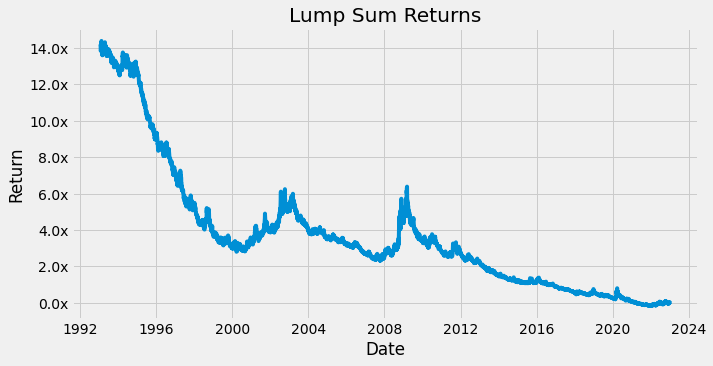

In [ ]:
# Calculate lump sum returns.
n_shares = in_total / spy["Adj Close"]
out_total = n_shares * spy["Adj Close"].values[-1]
lump_sum = (out_total - in_total) / in_total

plot_returns(lump_sum, "Lump Sum Returns")

### Dollar Cost Averaging

In [ ]:
def dollar_cost_average(start_date, n_periods, freq, portion):
    investment_dates = pd.date_range(start=start_date, periods=n_periods, freq=freq)
    valid_dates = investment_dates[investment_dates < spy["Date"].values[-1]]
    closest_dates = spy["Date"].searchsorted(valid_dates)
    n_stocks = sum(portion / spy["Adj Close"][closest_dates])
    uninvested = portion * (len(investment_dates) - len(valid_dates))
    return spy["Adj Close"].values[-1] * n_stocks + uninvested 

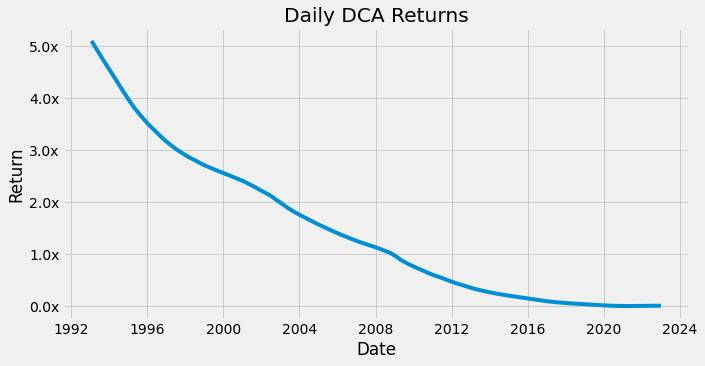

In [ ]:
# Dollar cost average every day.
n_days = len(spy)
portion = in_total / n_days

daily_dca = spy["Date"].map(
    lambda start_date: dollar_cost_average(
        start_date, n_periods=n_days, freq="1d", portion=portion
    )
)
daily_dca = (daily_dca - in_total) / in_total

plot_returns(daily_dca, "Daily DCA Returns")

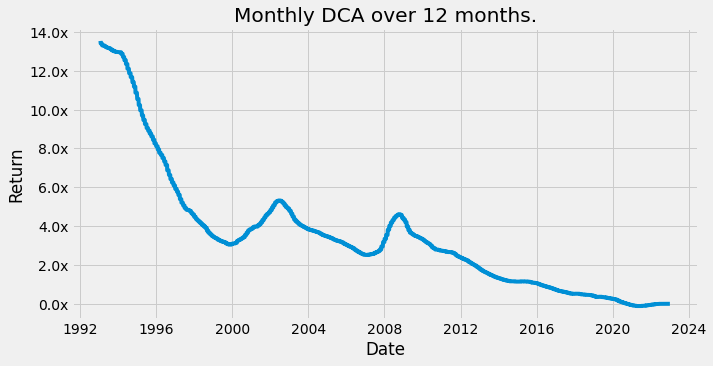

In [ ]:
# Monthly DCA over 12 months.
year_dca = spy["Date"].map(
    lambda start_date: dollar_cost_average(
        start_date, n_periods=12, freq="1m", portion=in_total/12
    )
)
year_dca = (year_dca - in_total) / in_total

plot_returns(year_dca, "Monthly DCA over 12 months.")

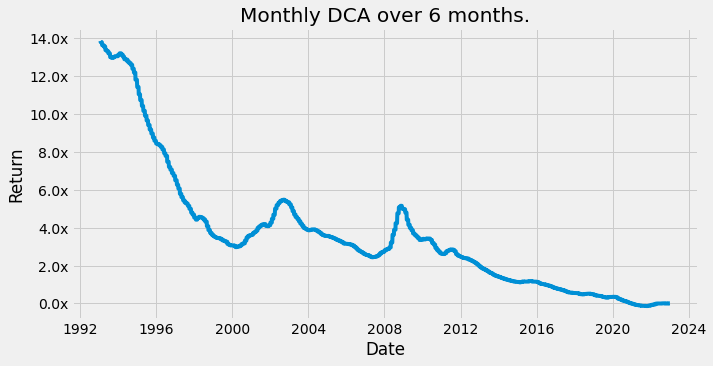

In [ ]:
# Monthly DCA over 6 months.
half_dca = spy["Date"].map(
    lambda start_date: dollar_cost_average(
        start_date, n_periods=6, freq="1m", portion=in_total/6
    )
)
half_dca = (half_dca - in_total) / in_total

plot_returns(half_dca, "Monthly DCA over 6 months.")

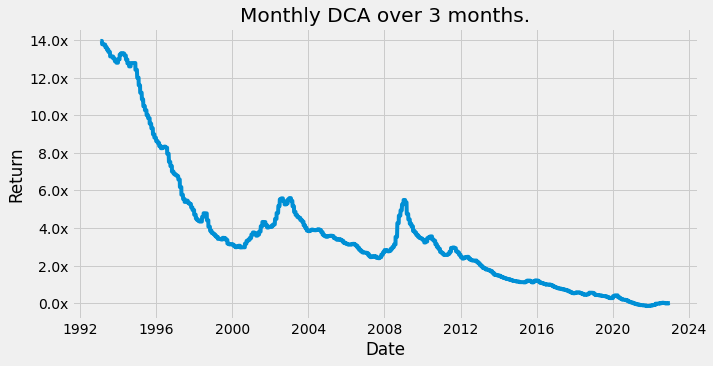

In [ ]:
# Monthly DCA over 3 months.
quarter_dca = spy["Date"].map(
    lambda start_date: dollar_cost_average(
        start_date, n_periods=3, freq="1m", portion=in_total/3
    )
)
quarter_dca = (quarter_dca - in_total) / in_total

plot_returns(quarter_dca, "Monthly DCA over 3 months.")

### Comparison

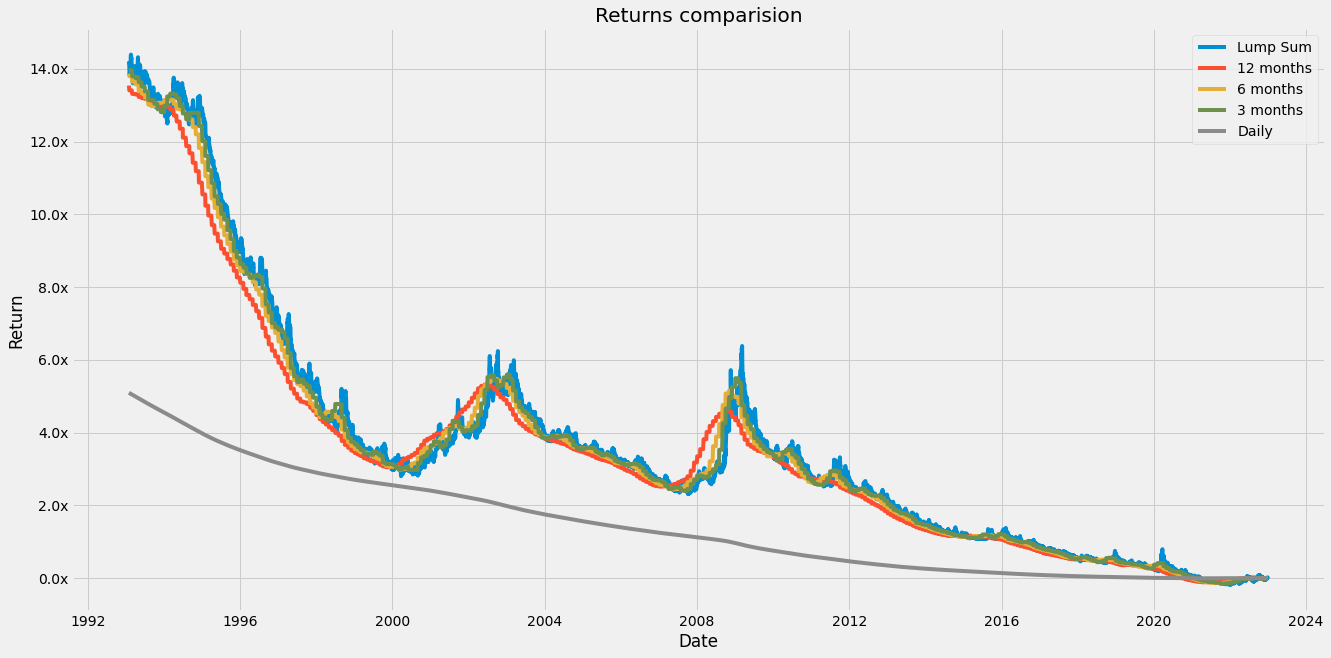

In [ ]:
plt.figure(figsize=(20,10))
ax = plt.subplot()
ax.plot(spy["Date"], lump_sum)
ax.plot(spy["Date"], year_dca)
ax.plot(spy["Date"], half_dca)
ax.plot(spy["Date"], quarter_dca)
ax.plot(spy["Date"], daily_dca)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.1f}x'.format(x)))
plt.title("Returns comparision")
plt.xlabel("Date")
plt.ylabel("Return");
plt.legend(["Lump Sum", "12 months", "6 months", "3 months", "Daily"])


References:
* https://www.tetralark.com/lumpsum_vs_dca/